##### Initialization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Flatten, TimeDistributed, ConvLSTM2D
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from tabulate import tabulate
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from itertools import product
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
# fix random seed for reproducibility
np.random.seed(7)

# Notebook

The folder time_series contains a list of files. Each file contains all the time series associated with a given product. Each time series corresponds to a company.

There are two types of files:

**- Wide**: each column corresponds to the time series of a company.

**- Long**: the information is stored in long format. The column company identifies the company, the colum timestamp the instant at which a price was recorded, and the column price the value of the price. These dataframes contain some other columns whose meaning will be explained next.

On the title of each file the Product Group (a product group corresponds to a group of time series of the same product sold by different companies) is identified by a number, called the product_group_id.

The file 'product_information' contains information about the products in each product group. This file contains the following columns:

- **offer_type** - offer type associated with that time series. A product can be locked, unlocked... to a certain operator.
- **product** - name of the product associated with time series
- **product_group_id** - uniquely identifies a product group. A product group is uniquely identified by its name and its offer_type.

**Example**: read a file and its product_information

In [2]:
# Select product_group_id
product_group_id = 958
# Read file
df = pd.read_pickle("Data/time_series_1/long_product_group_id_" + str(product_group_id))
df

,product_id,timestamp,product,country,company,product_group_id,offer_type,price
422267,3217,2020-06-21,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
422268,3217,2020-06-22,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
422269,3217,2020-06-23,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
422270,3217,2020-06-24,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
422271,3217,2020-06-25,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
...,...,...,...,...,...,...,...,...
426112,3230,2021-03-18,huawei Y9S 128GB,CL,Lider,958,unlocked,209.214955
426113,3230,2021-03-19,huawei Y9S 128GB,CL,Lider,958,unlocked,209.214955
426114,3230,2021-03-20,huawei Y9S 128GB,CL,Lider,958,unlocked,209.214955
426115,3230,2021-03-21,huawei Y9S 128GB,CL,Lider,958,unlocked,209.214955


In [3]:
# Read product information of the time series of that product group
product_information = pd.read_pickle("Data/product_information")
product_information

,product,offer_type
product_group_id,,
1,xiaomi Pocophone 128GB,unlocked
2,xiaomi Redmi Note 8 128GB,unlocked
5,xiaomi Redmi Note 9 Pro 64GB + AIWA AW 6,unlocked
6,xiaomi Redmi Note 9 Pro 64GB + AIWA AW 8,unlocked
7,blu Joy Adulto Mayor Sos,unlocked
...,...,...
952,huawei P30 128GB + P Smart 2019,unlocked
953,motorola Moto G7 Power 64GB,unlocked
956,nokia 6.1 32GB,unlocked


In [4]:
def get_product_wide(product_group_id, time_series='1'):
    return pd.read_pickle(f"Data/time_series_{time_series}/wide_product_group_id_{product_group_id}")

# Data Visualization

In [5]:
plt.rcParams['figure.dpi'] = 100
product_group_id = 958
time_series = '1'

df_wide = get_product_wide(product_group_id, time_series=time_series)
df_wide = df_wide.drop(["vtr", "macOnline"], axis=1)
print("Number of daily data: ", len(df_wide))

Number of daily data:  507


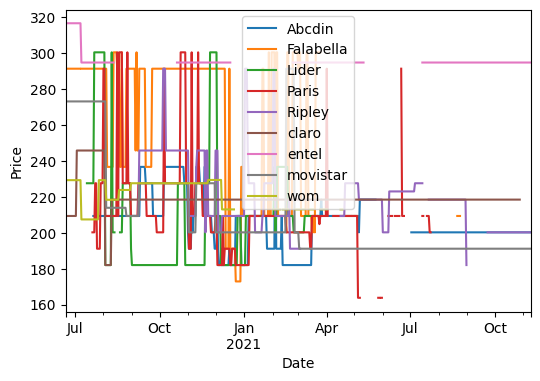

In [6]:
df_wide.plot()
plt.ylabel("Price")
plt.xlabel("Date")
plt.show()

Reduced the number of days so more companies have relevant data

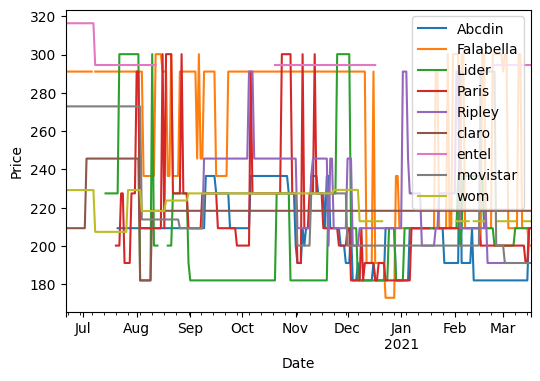

In [7]:
df_wide = df_wide[:270]
df_wide.plot()
plt.ylabel("Price")
plt.xlabel("Date")
plt.show()

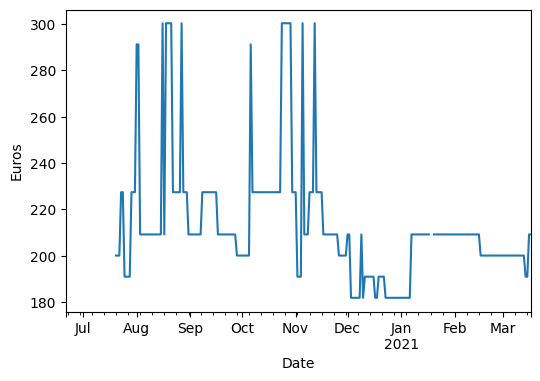

In [8]:
df_wide["Paris"].plot()
plt.ylabel('Euros')
plt.xlabel('Date')
plt.show()

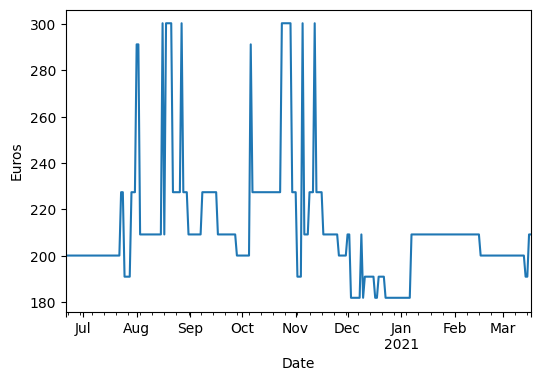

In [9]:
df_wide["Paris"].fillna(method='bfill', inplace=True)
df_wide["Paris"].fillna(method='ffill', inplace=True)
df_wide["Paris"].plot()
# plt.title(f"Paris's price variation over time for product group id {product_group_id}")
plt.ylabel('Euros')
plt.xlabel('Date')
plt.show()

Abcdin 270
Falabella 270
Lider 270
Paris 270
Ripley 270
claro 270
entel 270
movistar 270
wom 270


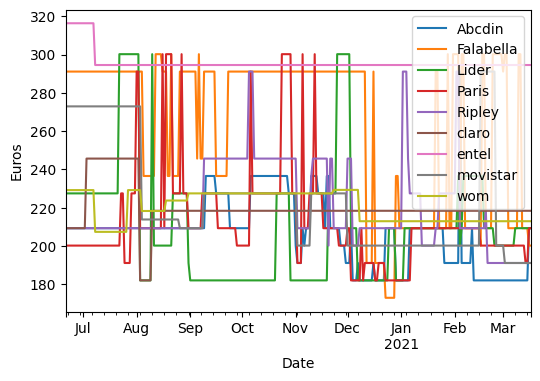

In [10]:
for comp in df_wide.keys():
    df_wide[comp].fillna(method='ffill', inplace=True)
    df_wide[comp].fillna(method='bfill', inplace=True)
    print(comp, len(df_wide[comp]))
df_wide.plot()
# plt.title(f"Companies price variation over time for product group id {product_group_id}")
plt.ylabel('Euros')
plt.xlabel('Date')
plt.show()

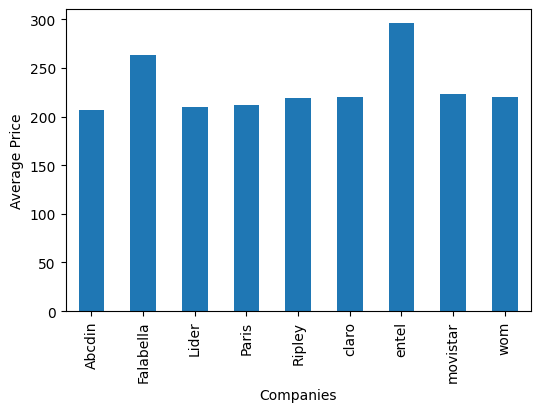

In [11]:
plt.ylabel("Average Price")
plt.xlabel("Companies")
df_wide.mean().plot(kind='bar')
plt.show()

## Signal Decomposition

### Multiplicative Model

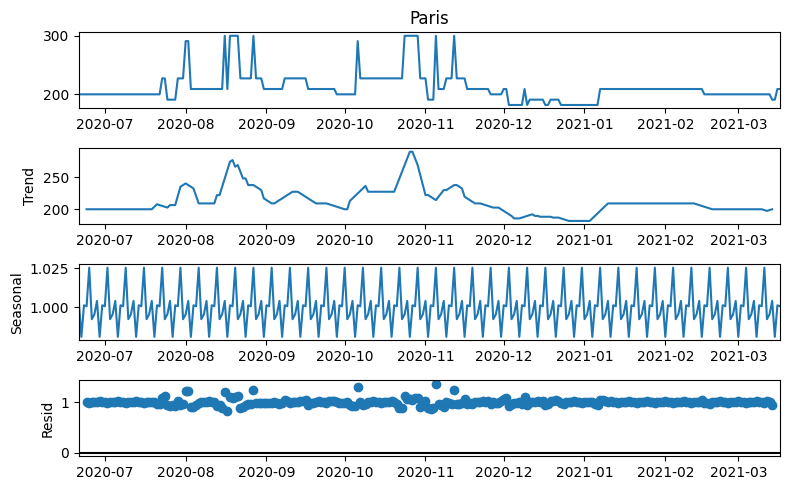

In [12]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100
components = seasonal_decompose(df_wide["Paris"], model='multiplicative', period=7)
components.plot()
plt.show()

### Additive Model

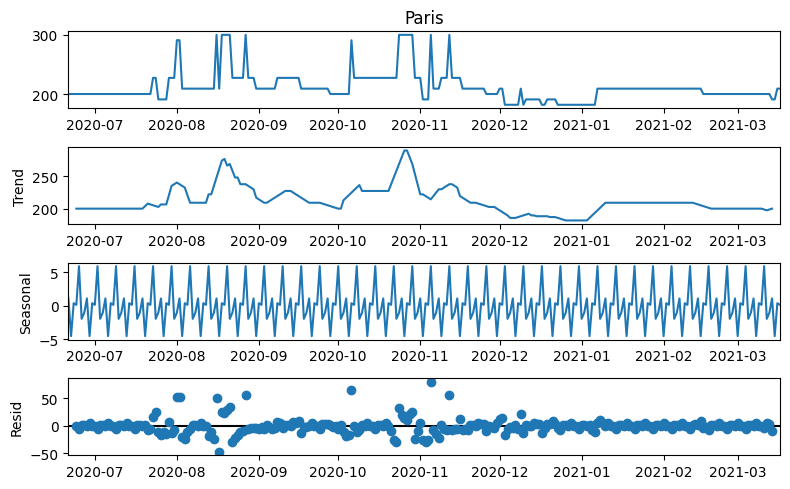

In [13]:
components = seasonal_decompose(df_wide["Paris"], model='additive', period=7)
components.plot()
plt.show()

In [14]:
product_group_id = 958
time_series = '1'
company = "Paris"
n_steps = 8 # number of days
train_split_amount = 0.7

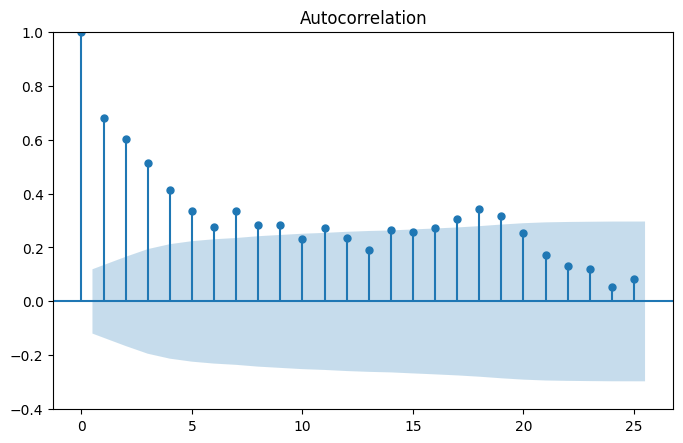

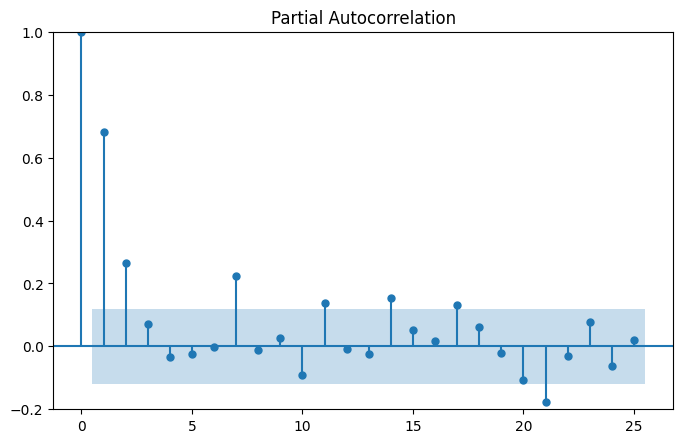

In [15]:
plot_acf(df_wide[company])
plt.ylim(-0.4)
plot_pacf(df_wide[company])
plt.ylim(-0.2)
plt.show()

In [16]:
# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(df_wide[company])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.2448865975075805
p-value: 0.017529114060020407


Since the p-value is higher than 0.05 we don't reject the null hypothesis with a high probability, meaning that data is not stationary.

# Define Evaluation metrics

In [17]:
product_group_id = 958
time_series = '1'
company = "Paris"
n_steps = 8 # number of days
train_split_amount = 0.7

def evaluate_pred(y_pred, y_test):
    mse = mean_squared_error(y_test, y_pred)
    mae = round(mean_absolute_error(y_test, y_pred), 4)
    rmse = str(round(np.sqrt(mse), 4))
    rmsle = str(round(np.log(np.sqrt(mse)), 4))
    mse = str(round(mse, 4))
    r2 = r2_score(y_test, y_pred)
    n = X_test.shape[0]
    k = X_test.shape[1]
    adjusted_r2 = str(round(1 - ((1-r2) * ((n-1)/(n-k-1))), 4))
    r2 = str(round(r2, 4))

    table = [
        ["Mean Absolute Error (MAE)", mae],
        ["Mean Squared Error (MSE)", mse],
        ["Root Mean Squared Error (RMSE)", rmse],
        ["Root Mean Squared Log Error (RMSLE)", rmsle],
        ["R Squared (R2)", r2],
        ["Adjusted R Squared (AR2)", adjusted_r2],
    ]
    print()
    print(tabulate(table, headers=["Metric", "Value"]))

    fig = plt.figure(figsize=(8, 4), dpi=100)
    plt.plot(y_test, color='b', label='real data')
    plt.plot(y_pred, color='r', label='predictions on test data')
    plt.title("Product Price Prediction")
    plt.xlabel('samples')
    plt.legend()
    plt.show()

    return [x[1] for x in table]

# Define Evaluation Strategy

In [18]:
n_epochs = 50
verbose = 0

# define evaluation strategy
def train_and_test_model(model, n_epochs=50, verbose=0):
    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=n_epochs, verbose=verbose)

    # get predictions on test data
    y_pred = model.predict(X_test, verbose=verbose)

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss function')
    plt.legend(['train', 'test'])
    plt.xlabel('iterations')

    return y_pred

# Univariate Models

## Get Train and Test Data

In [19]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

X_train = np.empty(shape=[0, n_steps], dtype=np.float32)
y_train = np.array([], dtype=np.float32)
X_test = np.empty(shape=[0, n_steps], dtype=np.float32)
y_test = np.array([], dtype=np.float32)

df_wide = get_product_wide(product_group_id, time_series)[:270]
if company in df_wide.keys():
    # DROP NAN VALUES
    df_wide[company].fillna(method='bfill', inplace=True)
    df_wide[company].fillna(method='ffill', inplace=True)
    prices = df_wide[company].values

    # SPLIT THE TIME SERIES OF PRICES INTO SEVERAL SHORT SEQUENCES
    X, y = split_sequence(prices, n_steps)

    # SPLIT INTO TRAIN AND TEST DATA
    train_size = int(len(y) * train_split_amount)
    test_size = len(y) - train_size

    # ADD DATA TO DATASET
    X_train = np.concatenate((X_train, X[0:train_size,:]))
    y_train = np.append(y_train, y[0:train_size])
    X_test = np.concatenate((X_test, X[train_size:,:]))
    y_test = np.append(y_test, y[train_size:])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(183, 8)
(183,)
(79, 8)
(79,)


## Normalizing Data

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))

# fit and apply the scaler on the TRAINING data
X_train = scaler.fit_transform(X_train)

# apply scaler on the TEST data
X_test = scaler.transform(X_test)

In [21]:
# We are working with a univariate series, so the number of features is one, for one variable.
n_features = 1
# reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
print(X_train.shape)
print(X_test.shape)

univariate_results = []

(183, 8, 1)
(79, 8, 1)


## ARIMA

### Making data stationary

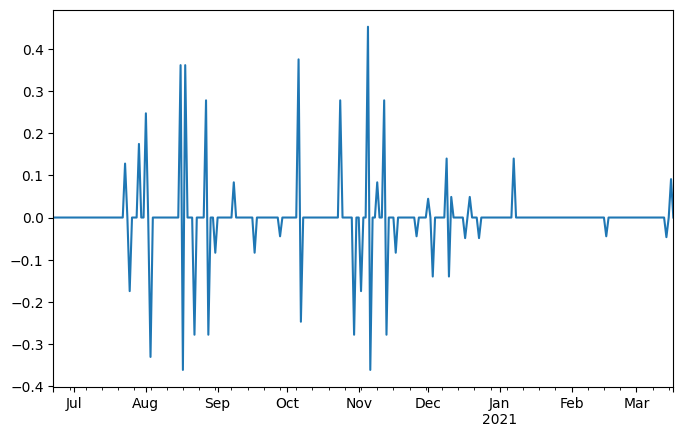

In [22]:
# Take the log difference to make data stationary
df_wide_stat = np.log(df_wide[company])
df_wide_stat = df_wide_stat.diff()
df_wide_stat = df_wide_stat.drop(df_wide_stat.index[0])
df_wide_stat.plot()
plt.show()

In [23]:
# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(df_wide_stat)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.853834245065497
p-value: 1.6678882181427777e-09


P-value less than 0.05 which means we reject the null hypothesis and data is now stationary.

In [24]:
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm(order_list):
        try:
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            print(f"{order} is not possible")
            continue
    
        results.append([order, model.aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [25]:
## Set the grid search parameters
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, exog=df_wide_stat[:train_size])

result_df

100%|██████████| 64/64 [00:16<00:00,  3.77it/s]


,"(p, d, q)",AIC
0,"(0, 1, 6)",-343.084483
1,"(6, 1, 1)",-341.405126
2,"(0, 1, 5)",-341.072167
3,"(1, 1, 7)",-340.615963
4,"(1, 1, 2)",-339.574846
...,...,...
59,"(5, 1, 0)",-289.368609
60,"(3, 1, 0)",-284.112990
61,"(2, 1, 0)",-267.242917
62,"(1, 1, 0)",-226.318796


In [26]:
best_order = result_df[result_df.AIC == result_df.AIC.min()]["(p, d, q)"].values[0]
best_order

(0, 1, 6)

                               SARIMAX Results                                
Dep. Variable:                  Paris   No. Observations:                  183
Model:               SARIMAX(0, 1, 6)   Log Likelihood                 178.542
Date:                Fri, 20 Jan 2023   AIC                           -343.084
Time:                        01:39:37   BIC                           -320.656
Sample:                    06-22-2020   HQIC                          -333.992
                         - 12-21-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.5097      0.060    -25.213      0.000      -1.627      -1.392
ma.L2          0.5391      0.088      6.119      0.000       0.366       0.712
ma.L3         -0.0551      0.111     -0.496      0.6

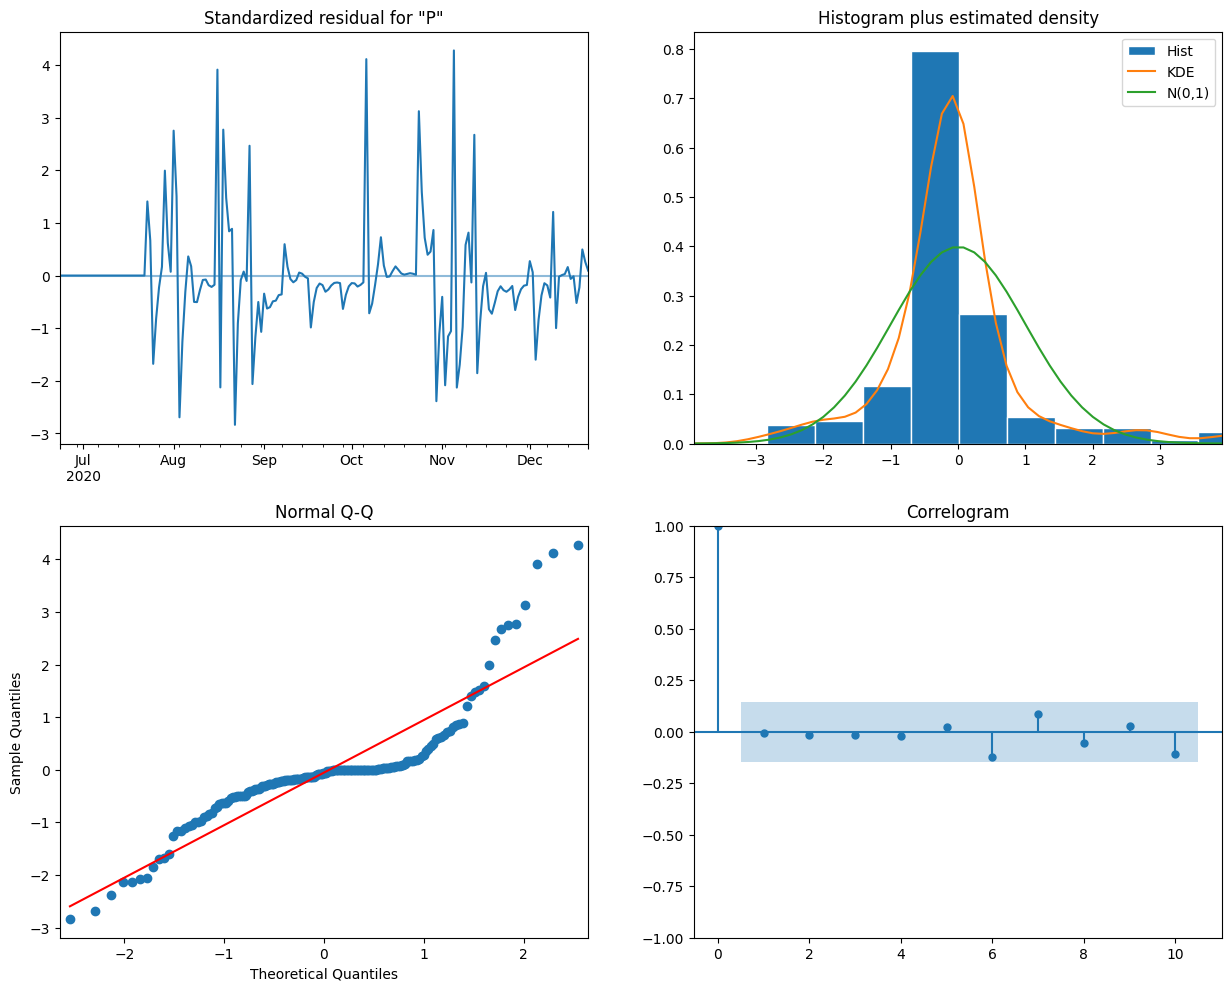

In [27]:
best_model = SARIMAX(df_wide_stat[:train_size], order=best_order).fit()
print(best_model.summary())
best_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [28]:
## Use the model to predict the next values in the time series

# Here we construct a more complete results object.
NN = len(df_wide[company]) + - train_size
print(f"Forcast on {NN} next values")
print(best_model.forecast(steps=NN))
fcast = best_model.get_forecast(steps=NN)

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 95%
print("Statistics of confidence intervals")
fcast.summary_frame(alpha=0.05)

Forcast on 87 next values
2020-12-22    0.002304
2020-12-23   -0.002868
2020-12-24   -0.011717
2020-12-25   -0.006712
2020-12-26   -0.003554
                ...   
2021-03-14   -0.002156
2021-03-15   -0.002156
2021-03-16   -0.002156
2021-03-17   -0.002156
2021-03-18   -0.002156
Freq: D, Name: predicted_mean, Length: 87, dtype: float64
Statistics of confidence intervals


Paris,mean,mean_se,mean_ci_lower,mean_ci_upper
2020-12-22,0.002304,0.088983,-0.172100,0.176708
2020-12-23,-0.002868,0.099874,-0.198618,0.192881
2020-12-24,-0.011717,0.099908,-0.207533,0.184100
2020-12-25,-0.006712,0.099934,-0.202579,0.189156
2020-12-26,-0.003554,0.100173,-0.199889,0.192782
...,...,...,...,...
2021-03-14,-0.002156,0.101287,-0.200674,0.196362
2021-03-15,-0.002156,0.101287,-0.200675,0.196363
2021-03-16,-0.002156,0.101288,-0.200677,0.196365
2021-03-17,-0.002156,0.101288,-0.200678,0.196366



Metric                                  Value
-----------------------------------  --------
Mean Absolute Error (MAE)              8.0338
Mean Squared Error (MSE)             101.411
Root Mean Squared Error (RMSE)        10.0703
Root Mean Squared Log Error (RMSLE)    2.3096
R Squared (R2)                        -0.0129
Adjusted R Squared (AR2)              -0.1286


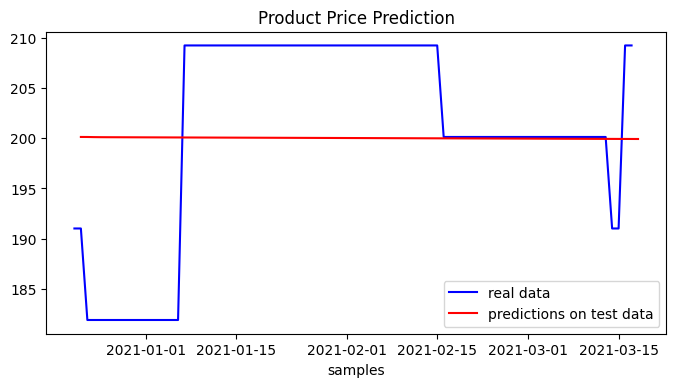

In [29]:
# evaluate the model predictions
y_pred = fcast.summary_frame(alpha=0.05)["mean"]
y_pred.iloc[0] = df_wide[company].iloc[0]
y_pred = y_pred.cumsum()
metrics = evaluate_pred(y_pred, df_wide[company][train_size:])
metrics.insert(0, "ARIMA")
univariate_results.append(metrics)

## SARIMA

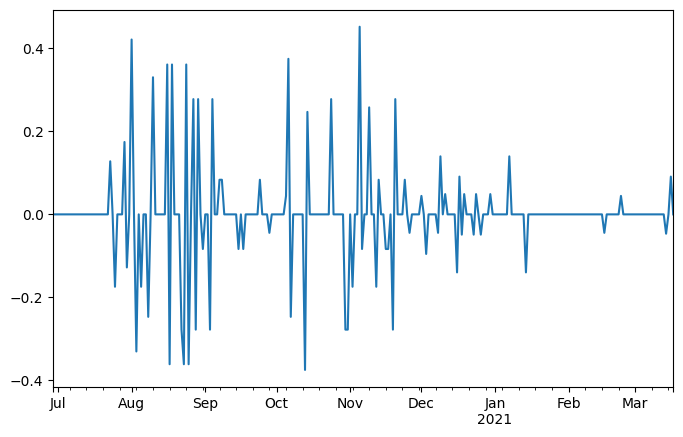

In [30]:
# Take the log difference to make data stationary
# Seasonal differencing
df_wide_stat = df_wide_stat.diff(7)
df_wide_stat = df_wide_stat.drop([df_wide_stat.index[0], df_wide_stat.index[1],
    df_wide_stat.index[2], df_wide_stat.index[3], df_wide_stat.index[4],
    df_wide_stat.index[5], df_wide_stat.index[6]], axis=0)
df_wide_stat.plot()
plt.show()

In [31]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            print(f"{order} is not possible")
            continue
        results.append([param, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [32]:
## SARIMA grid of hyperparameters
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 7 # a season was considered to be a week

parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

result_df = optimize_SARIMA(parameters_list, d, D, s, df_wide_stat[:train_size])
result_df

256


100%|██████████| 256/256 [03:28<00:00,  1.23it/s]


,"(p,q)x(P,Q)",AIC
0,"(0, 2, 0, 2)",-245.539921
1,"(1, 2, 0, 2)",-245.450061
2,"(1, 2, 0, 3)",-245.304336
3,"(0, 2, 1, 2)",-244.889934
4,"(0, 2, 0, 3)",-244.695847
...,...,...
251,"(2, 0, 0, 0)",15.690534
252,"(0, 0, 2, 0)",16.518379
253,"(0, 0, 1, 0)",39.303422
254,"(1, 0, 0, 0)",71.911738


In [33]:
# Choose the values that minimize the AIC score
best_values = result_df[result_df.AIC == result_df.AIC.min()]["(p,q)x(P,Q)"].values[0]
best_order = (best_values[0], d, best_values[1])
print(best_order)
best_seasonal_order = (best_values[2], D, best_values[3], s)
print(best_seasonal_order)

(0, 1, 2)
(0, 1, 2, 7)


                                     SARIMAX Results                                     
Dep. Variable:                             Paris   No. Observations:                  183
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 7)   Log Likelihood                 127.770
Date:                           Fri, 20 Jan 2023   AIC                           -245.540
Time:                                   01:43:07   BIC                           -229.716
Sample:                               06-29-2020   HQIC                          -239.121
                                    - 12-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.4314      1.721     -0.832      0.405      -4.804       1.941
ma.L2          0.4322      0.723      0.597

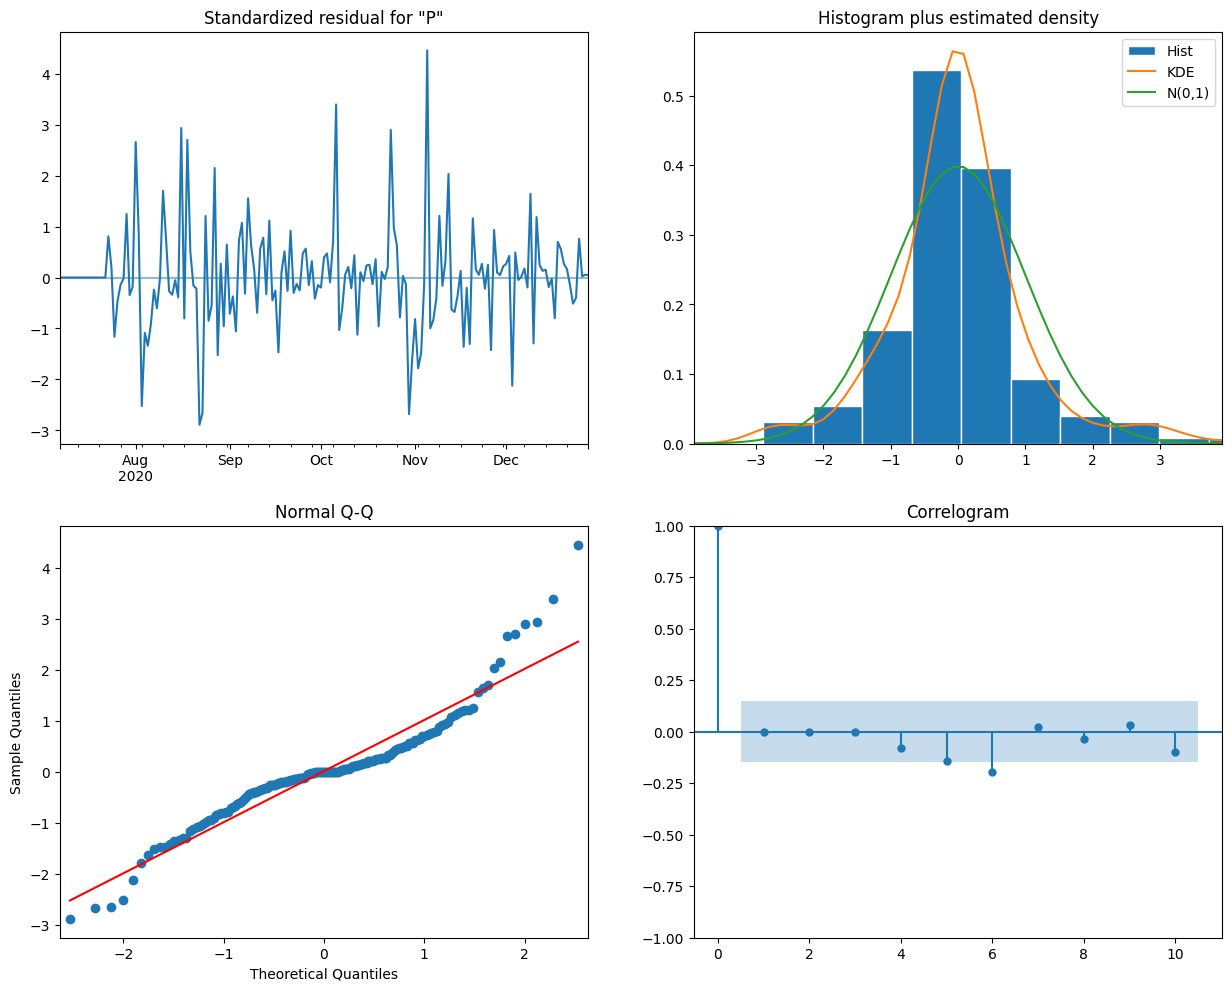

In [34]:
best_model = SARIMAX(df_wide_stat[:train_size], order=best_order, seasonal_order=best_seasonal_order).fit(dis=-1)
print(best_model.summary())
best_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [35]:
## Use the model to predict the next values in the time series

# Here we construct a more complete results object.
NN = len(df_wide[company]) - train_size
print(f"Forcast on {NN} next values")
print(best_model.forecast(steps=NN))
fcast = best_model.get_forecast(steps=NN)

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 95%
print("Statistics of confidence intervals")
fcast.summary_frame(alpha=0.05)

Forcast on 87 next values
2020-12-29    0.014885
2020-12-30    0.037747
2020-12-31    0.015072
2021-01-01   -0.081086
2021-01-02    0.026832
                ...   
2021-03-21   -0.001761
2021-03-22    0.001967
2021-03-23   -0.001548
2021-03-24   -0.001158
2021-03-25   -0.001413
Freq: D, Name: predicted_mean, Length: 87, dtype: float64
Statistics of confidence intervals


Paris,mean,mean_se,mean_ci_lower,mean_ci_upper
2020-12-29,0.014885,0.098182,-0.177548,0.207319
2020-12-30,0.037747,0.105902,-0.169817,0.245311
2020-12-31,0.015072,0.105902,-0.192492,0.222637
2021-01-01,-0.081086,0.105902,-0.288650,0.126479
2021-01-02,0.026832,0.105902,-0.180732,0.234396
...,...,...,...,...
2021-03-21,-0.001761,0.139586,-0.275344,0.271822
2021-03-22,0.001967,0.139587,-0.271618,0.275552
2021-03-23,-0.001548,0.139591,-0.275142,0.272046
2021-03-24,-0.001158,0.139591,-0.274750,0.272435



Metric                                  Value
-----------------------------------  --------
Mean Absolute Error (MAE)              7.9727
Mean Squared Error (MSE)             101.011
Root Mean Squared Error (RMSE)        10.0504
Root Mean Squared Log Error (RMSLE)    2.3076
R Squared (R2)                        -0.0089
Adjusted R Squared (AR2)              -0.1242


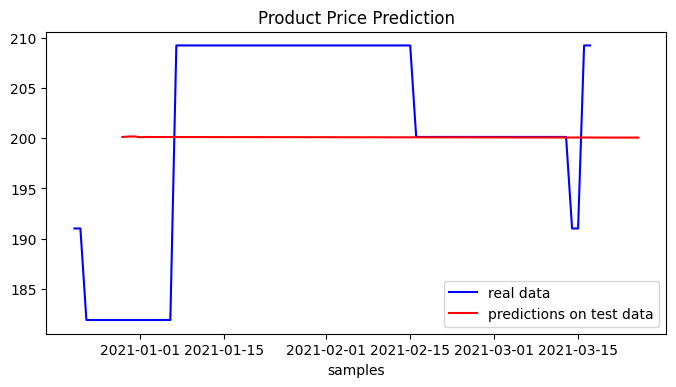

In [36]:
# evaluate the model predictions
y_pred = fcast.summary_frame(alpha=0.05)["mean"]
y_pred.iloc[0] = df_wide[company].iloc[0]
y_pred = y_pred.cumsum()
metrics = evaluate_pred(y_pred, df_wide[company][train_size:])
metrics.insert(0, "SARIMA")
univariate_results.append(metrics)

## Exponential Smoothing


Metric                                  Value
-----------------------------------  --------
Mean Absolute Error (MAE)             14.3267
Mean Squared Error (MSE)             254.638
Root Mean Squared Error (RMSE)        15.9574
Root Mean Squared Log Error (RMSLE)    2.7699
R Squared (R2)                        -1.5433
Adjusted R Squared (AR2)              -1.8339


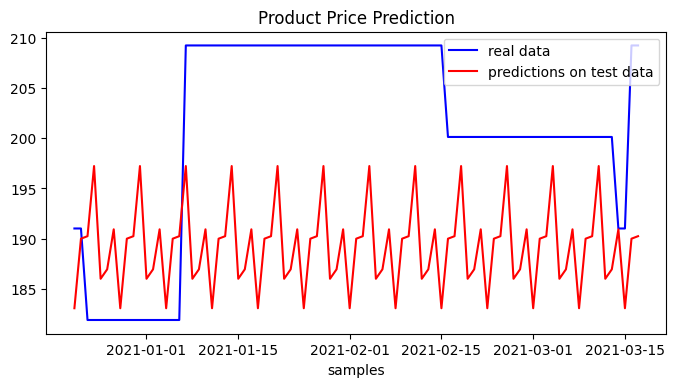

In [37]:
model = ExponentialSmoothing(df_wide[company][:train_size], seasonal='mul', seasonal_periods=7).fit()
y_pred = model.predict(start=df_wide[company][train_size:].index[0], end=df_wide[company][train_size:].index[-1])
# evaluate the model predictions
metrics = evaluate_pred(y_pred, df_wide[company][train_size:])
metrics.insert(0, "Exponential Smoothing")
univariate_results.append(metrics)

## Vanilla LSTM

In [38]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


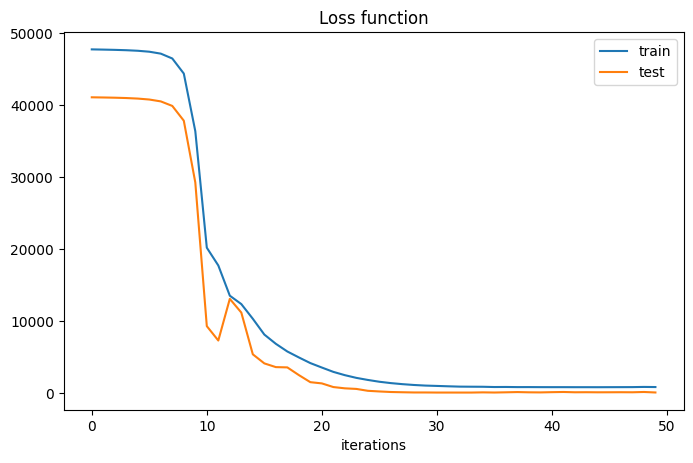

In [39]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                 Value
-----------------------------------  -------
Mean Absolute Error (MAE)             5.4818
Mean Squared Error (MSE)             63.1917
Root Mean Squared Error (RMSE)        7.9493
Root Mean Squared Log Error (RMSLE)   2.0731
R Squared (R2)                        0.1834
Adjusted R Squared (AR2)              0.09


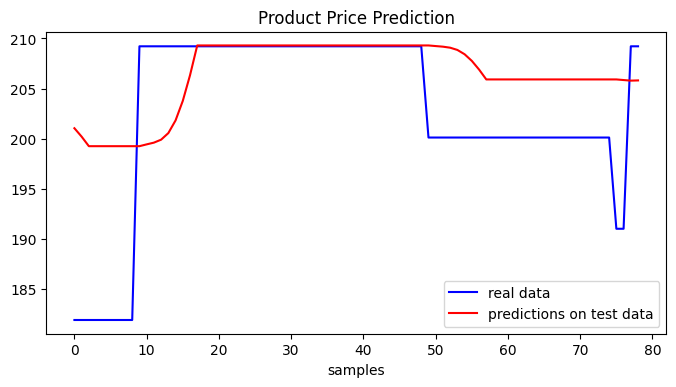

In [40]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "Vanilla LSTM")
univariate_results.append(metrics)

## Stacked LSTM

In [41]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 8, 50)             10400     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


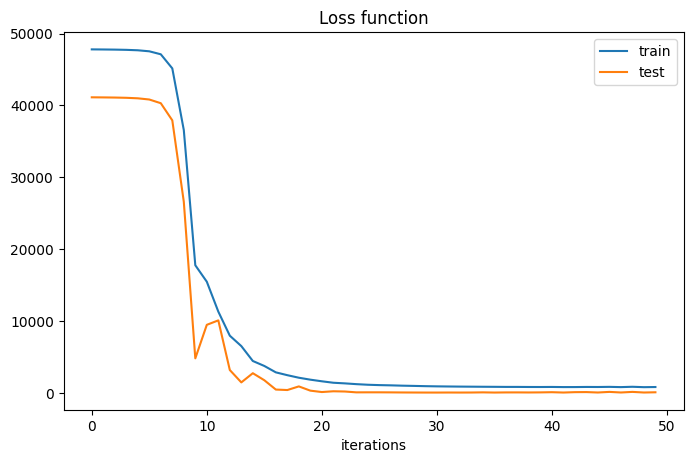

In [42]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                 Value
-----------------------------------  -------
Mean Absolute Error (MAE)             7.5951
Mean Squared Error (MSE)             88.2186
Root Mean Squared Error (RMSE)        9.3925
Root Mean Squared Log Error (RMSLE)   2.2399
R Squared (R2)                       -0.1401
Adjusted R Squared (AR2)             -0.2704


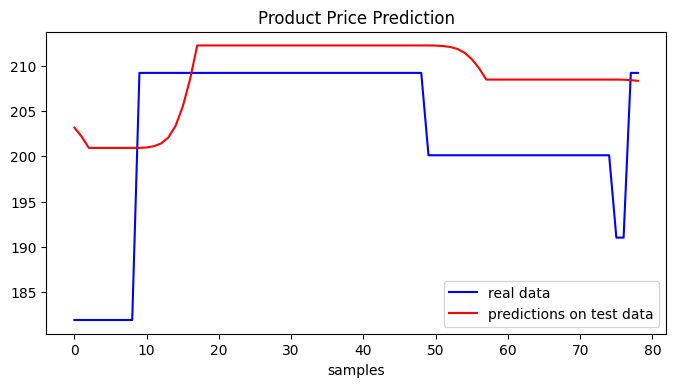

In [43]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "Stacked LSTM")
univariate_results.append(metrics)

## Bidirectional LSTM

In [44]:
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

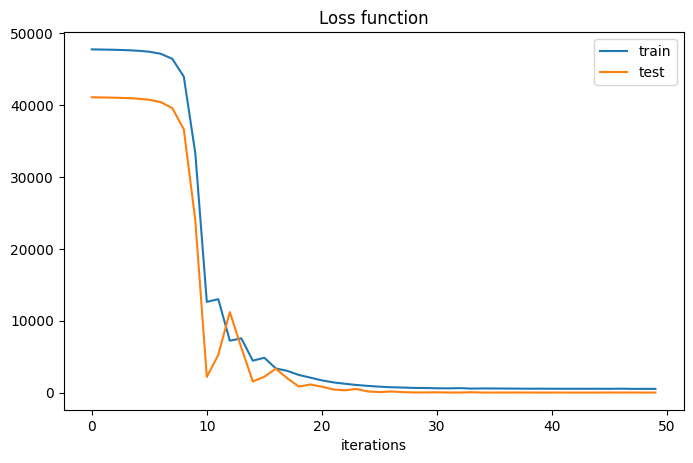

In [45]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                 Value
-----------------------------------  -------
Mean Absolute Error (MAE)             3.3978
Mean Squared Error (MSE)             23.5453
Root Mean Squared Error (RMSE)        4.8524
Root Mean Squared Log Error (RMSLE)   1.5795
R Squared (R2)                        0.6957
Adjusted R Squared (AR2)              0.6609


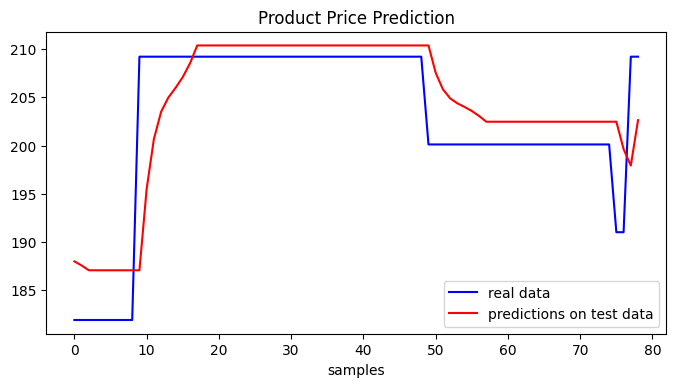

In [46]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "Bidirectional LSTM")
univariate_results.append(metrics)

## CNN LSTM

In [47]:
# reshape from [samples, timesteps, features] into [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 2
n_sub_steps = 4
X_train = X_train.reshape((X_train.shape[0], n_seq, n_sub_steps, n_features))
X_test = X_test.reshape((X_test.shape[0], n_seq, n_sub_steps, n_features))
print(X_train.shape)
print(X_test.shape)


(183, 2, 4, 1)
(79, 2, 4, 1)


In [48]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_sub_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

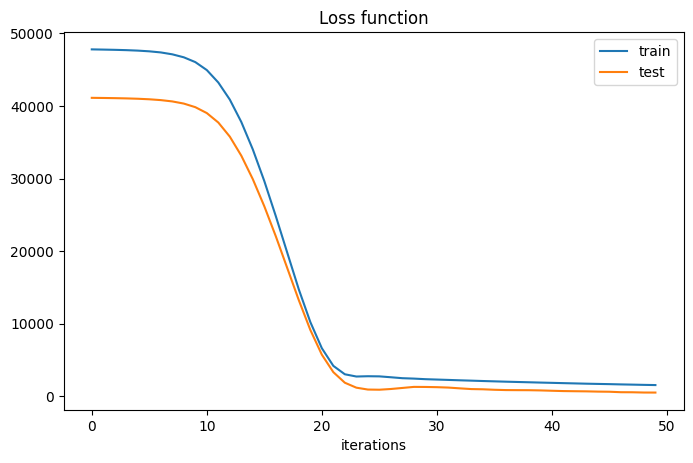

In [49]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                  Value
-----------------------------------  --------
Mean Absolute Error (MAE)             20.7177
Mean Squared Error (MSE)             537.275
Root Mean Squared Error (RMSE)        23.1792
Root Mean Squared Log Error (RMSLE)    3.1433
R Squared (R2)                        -5.9433
Adjusted R Squared (AR2)              -6.1261


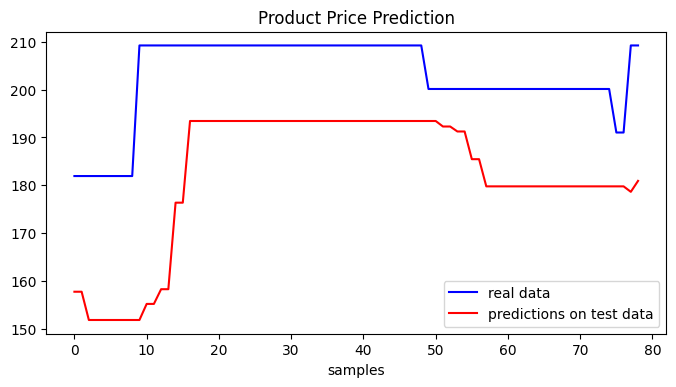

In [50]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "CNN LSTM")
univariate_results.append(metrics)

## ConvLSTM

In [51]:
X_train = X_train.reshape((X_train.shape[0], n_seq, 1, n_sub_steps, n_features))
X_test = X_test.reshape((X_test.shape[0], n_seq, 1, n_sub_steps, n_features))
print(X_train.shape)
print(X_test.shape)

(183, 2, 1, 4, 1)
(79, 2, 1, 4, 1)


In [52]:
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_sub_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

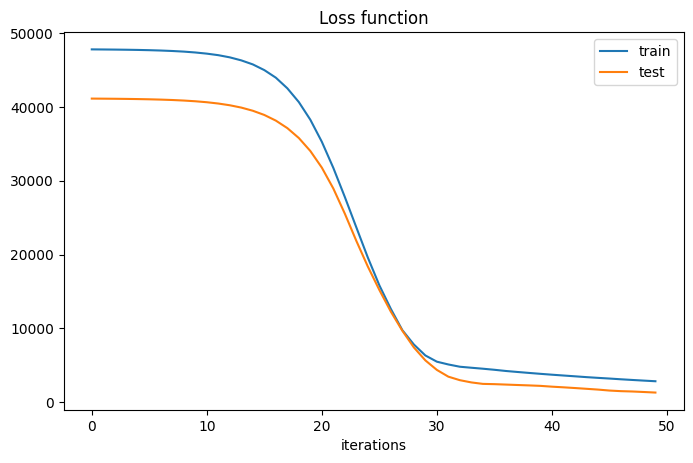

In [53]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                   Value
-----------------------------------  ---------
Mean Absolute Error (MAE)              32.6755
Mean Squared Error (MSE)             1307.11
Root Mean Squared Error (RMSE)         36.154
Root Mean Squared Log Error (RMSLE)     3.5878
R Squared (R2)                        -15.8921
Adjusted R Squared (AR2)              -16.3367


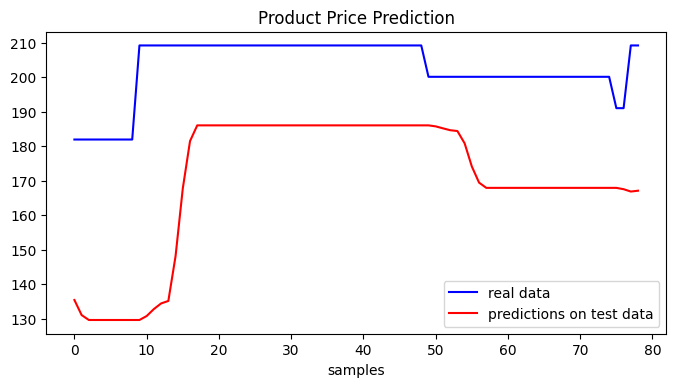

In [54]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "ConvLSTM")
univariate_results.append(metrics)

## Models Results

In [55]:
print(tabulate(univariate_results,
               headers=["Univariate Model", "MAE", "MSE", "RMSE", "RMSLE", "R2", "AR2"], tablefmt='latex_booktabs'
               ))

tabulate(univariate_results,
         headers=["Univariate Model", "MAE", "MSE", "RMSE", "RMSLE", "R2", "AR2"], tablefmt='html'
         )

\begin{tabular}{lrrrrrr}
\toprule
 Univariate Model      &     MAE &       MSE &    RMSE &   RMSLE &       R2 &      AR2 \\
\midrule
 ARIMA                 &  8.0338 &  101.411  & 10.0703 &  2.3096 &  -0.0129 &  -0.1286 \\
 SARIMA                &  7.9727 &  101.011  & 10.0504 &  2.3076 &  -0.0089 &  -0.1242 \\
 Exponential Smoothing & 14.3267 &  254.638  & 15.9574 &  2.7699 &  -1.5433 &  -1.8339 \\
 Vanilla LSTM          &  5.4818 &   63.1917 &  7.9493 &  2.0731 &   0.1834 &   0.09   \\
 Stacked LSTM          &  7.5951 &   88.2186 &  9.3925 &  2.2399 &  -0.1401 &  -0.2704 \\
 Bidirectional LSTM    &  3.3978 &   23.5453 &  4.8524 &  1.5795 &   0.6957 &   0.6609 \\
 CNN LSTM              & 20.7177 &  537.275  & 23.1792 &  3.1433 &  -5.9433 &  -6.1261 \\
 ConvLSTM              & 32.6755 & 1307.11   & 36.154  &  3.5878 & -15.8921 & -16.3367 \\
\bottomrule
\end{tabular}


Univariate Model,MAE,MSE,RMSE,RMSLE,R2,AR2
ARIMA,8.0338,101.411,10.0703,2.3096,-0.0129,-0.1286
SARIMA,7.9727,101.011,10.0504,2.3076,-0.0089,-0.1242
Exponential Smoothing,14.3267,254.638,15.9574,2.7699,-1.5433,-1.8339
Vanilla LSTM,5.4818,63.1917,7.9493,2.0731,0.1834,0.09
Stacked LSTM,7.5951,88.2186,9.3925,2.2399,-0.1401,-0.2704
Bidirectional LSTM,3.3978,23.5453,4.8524,1.5795,0.6957,0.6609
CNN LSTM,20.7177,537.275,23.1792,3.1433,-5.9433,-6.1261
ConvLSTM,32.6755,1307.11,36.154,3.5878,-15.8921,-16.3367


# Multivariate Models

## Get Train and Test Data

Abcdin 270
Falabella 270
Lider 270
Paris 270
Ripley 270
claro 270
entel 270
movistar 270
wom 270


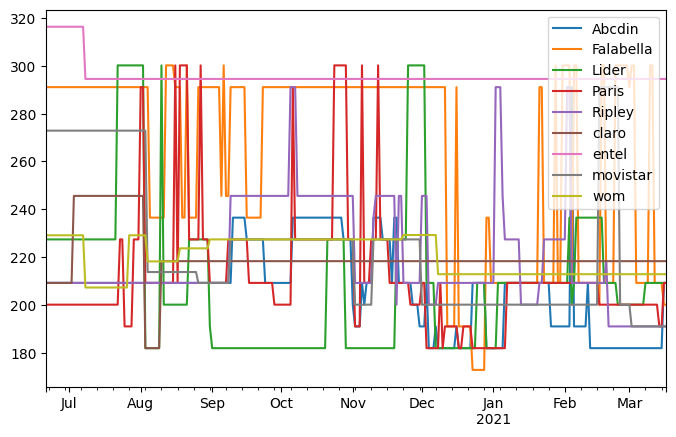

In [56]:
df_wide = get_product_wide(product_group_id, time_series)[:270]
df_wide = df_wide.drop(["vtr", "macOnline"], axis=1)
for comp in df_wide.keys():
    df_wide[comp].fillna(method='bfill', inplace=True)
    df_wide[comp].fillna(method='ffill', inplace=True)
    print(comp, len(df_wide[comp]))
df_wide.plot()
n_days = len(df_wide)
n_companies = len(df_wide.keys())
company = "Paris"

In [57]:
X_train = np.empty(shape=[0, n_steps, n_companies], dtype=np.float32)
y_train = np.empty(shape=[0], dtype=np.float32)
X_test = np.empty(shape=[0, n_steps, n_companies], dtype=np.float32)
y_test = np.empty(shape=[0], dtype=np.float32)

X, y = list(), list()

# GET PRICES DATA OF THAT COMPANY
prices = df_wide[company].values

for i in range(n_days):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > n_days-1:
        break
    seq_x = []
    # gather input of the pattern from all companies
    for j in range(i, end_ix):
        temp_seq = []
        for comp in df_wide.keys():
            temp_seq.append(df_wide[comp].values[j])
        seq_x.append(temp_seq)
    # gather the output parts of the chosen company
    y.append(prices[end_ix])
    X.append(seq_x)

X, y = np.array(X), np.array(y)

# SPLIT INTO TRAIN AND TEST DATA
train_size = int(len(y) * train_split_amount)
test_size = len(y) - train_size

# ADD DATA TO DATASET
X_train = np.concatenate((X_train, X[0:train_size,:]))
y_train = np.append(y_train, y[0:train_size])
X_test = np.concatenate((X_test, X[train_size:,:]))
y_test = np.append(y_test, y[train_size:])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(183, 8, 9)
(183,)
(79, 8, 9)
(79,)


In [58]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
print(X_train.shape)
print(X_test.shape)

(183, 72)
(79, 72)


## Normalize Features

In [59]:
scaler = MinMaxScaler(feature_range=(0, 1))

# fit and apply the scaler on the TRAINING data
X_train = scaler.fit_transform(X_train)

# apply scaler on the TEST data
X_test = scaler.transform(X_test)

In [60]:
X_train = X_train.reshape(X_train.shape[0], n_steps, n_companies)
X_test = X_test.reshape(X_test.shape[0], n_steps, n_companies)

print(X_train.shape)
print(X_test.shape)

(183, 8, 9)
(79, 8, 9)


In [61]:
multivariate_results = []

## VARMA

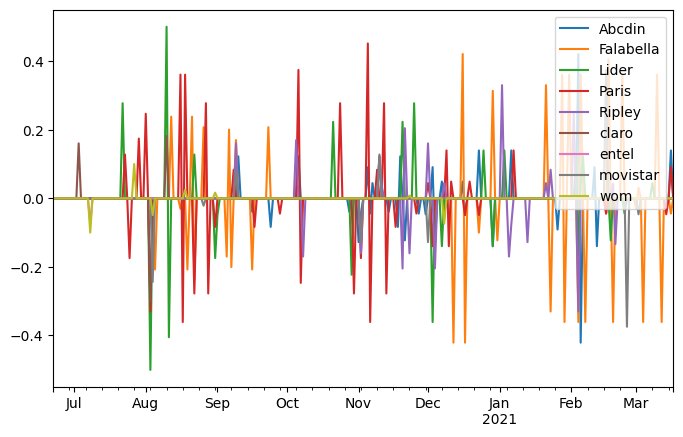

In [62]:
# Take the log difference to make data stationary
df_wide_stat = np.log(df_wide)
df_wide_stat = df_wide_stat.diff()
df_wide_stat = df_wide_stat.drop(df_wide_stat.index[0])
df_wide_stat.plot()
plt.show()

In [63]:
def optimize_VARMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm(order_list):
        # try:
        model = VARMAX(exog, order=order, enforce_stationarity=False,
                                enforce_invertibility=False).fit(disp=-1)
        # except:
        #     print(f"{order} is not possible")
        #     continue
    
        results.append([order, model.aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [64]:
## Set the grid search parameters
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)

result_df = optimize_VARMA(order_list, df_wide_stat[:train_size])

result_df

100%|██████████| 64/64 [3:10:52<00:00, 178.95s/it]  


,"(p, d, q)",AIC
0,"(1, 1, 7)",-6662.686365
1,"(1, 1, 6)",-6662.686365
2,"(1, 1, 5)",-6662.686365
3,"(1, 1, 4)",-6662.686365
4,"(1, 1, 3)",-6662.686365
...,...,...
59,"(4, 1, 4)",-6401.734569
60,"(4, 1, 3)",-6401.734569
61,"(4, 1, 2)",-6401.734569
62,"(4, 1, 1)",-6401.734569


In [65]:
best_order = result_df[result_df.AIC == result_df.AIC.min()]["(p, d, q)"].values[0]
best_order

(1, 1, 7)

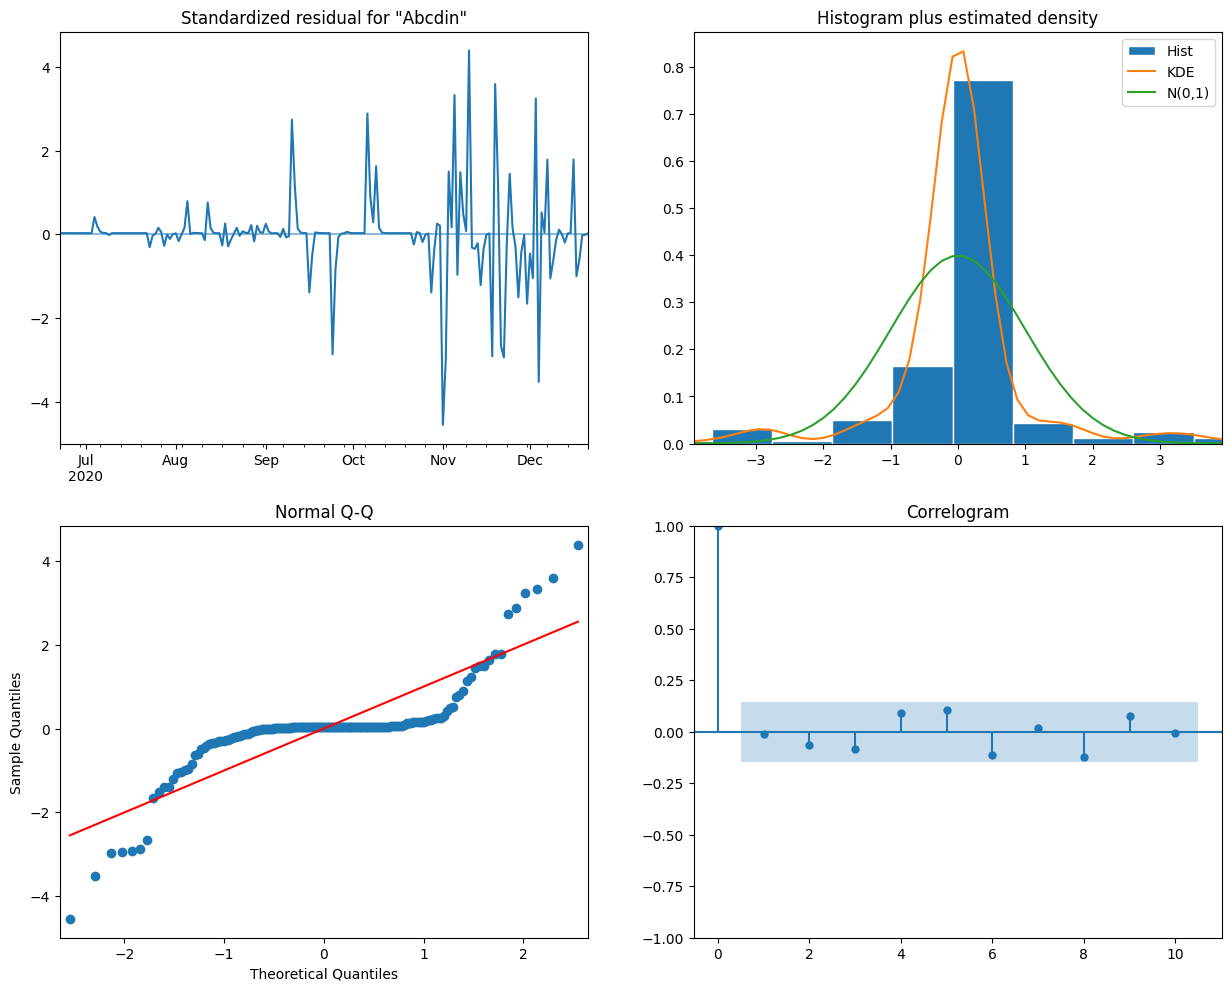

In [67]:
best_model = VARMAX(df_wide_stat[:train_size], order=best_order, enforce_stationarity=False,
                                enforce_invertibility=False).fit(disp=-1)
best_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [68]:
## Use the model to predict the next values in the time series

# Here we construct a more complete results object.
NN = len(df_wide[company]) - train_size
print(f"Forcast on {NN} next values")
print(best_model.forecast(steps=NN))
fcast = best_model.get_forecast(steps=NN)

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 95%
print("Statistics of confidence intervals")
fcast.summary_frame(endog=4, alpha=0.05) 

Forcast on 87 next values
              Abcdin  Falabella     Lider     Paris    Ripley     claro  \
2020-12-22 -0.000763  -0.003255 -0.001024 -0.000746  0.000154  0.000190   
2020-12-23 -0.000730  -0.002127 -0.001270 -0.000002 -0.000044  0.000220   
2020-12-24 -0.000792  -0.002384 -0.001220 -0.000400 -0.000006  0.000226   
2020-12-25 -0.000769  -0.002289 -0.001252 -0.000226 -0.000021  0.000222   
2020-12-26 -0.000778  -0.002325 -0.001238 -0.000303 -0.000015  0.000224   
...              ...        ...       ...       ...       ...       ...   
2021-03-14 -0.000776  -0.002315 -0.001242 -0.000280 -0.000017  0.000223   
2021-03-15 -0.000776  -0.002315 -0.001242 -0.000280 -0.000017  0.000223   
2021-03-16 -0.000776  -0.002315 -0.001242 -0.000280 -0.000017  0.000223   
2021-03-17 -0.000776  -0.002315 -0.001242 -0.000280 -0.000017  0.000223   
2021-03-18 -0.000776  -0.002315 -0.001242 -0.000280 -0.000017  0.000223   

               entel  movistar       wom  
2020-12-22 -0.000396 -0.001820

Ripley,mean,mean_se,mean_ci_lower,mean_ci_upper
2020-12-22,0.000154,0.038747,-0.075790,0.076097
2020-12-23,-0.000044,0.040345,-0.079120,0.079031
2020-12-24,-0.000006,0.040568,-0.079518,0.079507
2020-12-25,-0.000021,0.040600,-0.079596,0.079554
2020-12-26,-0.000015,0.040604,-0.079597,0.079567
...,...,...,...,...
2021-03-14,-0.000017,0.040604,-0.079600,0.079566
2021-03-15,-0.000017,0.040604,-0.079600,0.079566
2021-03-16,-0.000017,0.040604,-0.079600,0.079566
2021-03-17,-0.000017,0.040604,-0.079600,0.079566



Metric                                  Value
-----------------------------------  --------
Mean Absolute Error (MAE)              7.9565
Mean Squared Error (MSE)             100.891
Root Mean Squared Error (RMSE)        10.0445
Root Mean Squared Log Error (RMSLE)    2.307
R Squared (R2)                        -0.0077
Adjusted R Squared (AR2)              -0.1228


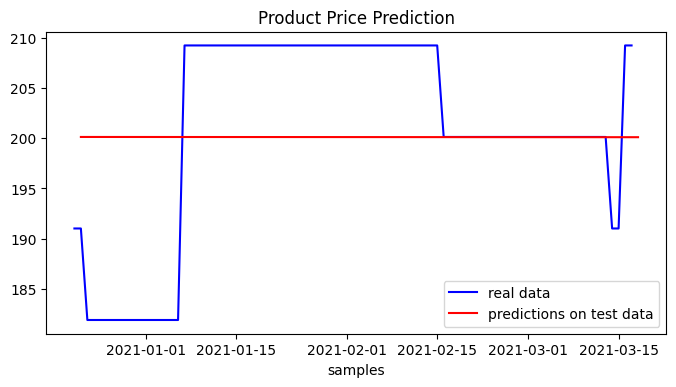

In [69]:
# evaluate the model predictions
y_pred = best_model.forecast(steps=NN)[company]
y_pred.iloc[0] = df_wide[company].iloc[0]
y_pred = y_pred.cumsum()
metrics = evaluate_pred(y_pred, df_wide[company][train_size:])
metrics.insert(0, "VARMA")
multivariate_results.append(metrics)

## Vanilla LSTM

In [70]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_companies)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50)                12000     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 12,051
Trainable params: 12,051
Non-trainable params: 0
_________________________________________________________________


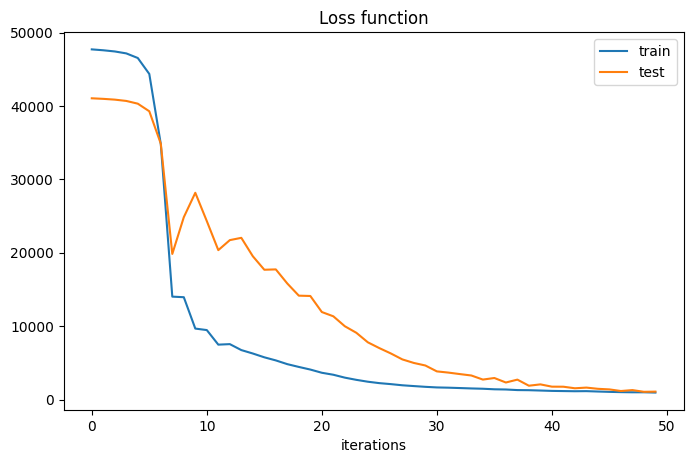

In [71]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                   Value
-----------------------------------  ---------
Mean Absolute Error (MAE)              25.1447
Mean Squared Error (MSE)             1092.75
Root Mean Squared Error (RMSE)         33.0567
Root Mean Squared Log Error (RMSLE)     3.4982
R Squared (R2)                        -13.1218
Adjusted R Squared (AR2)              -14.7358


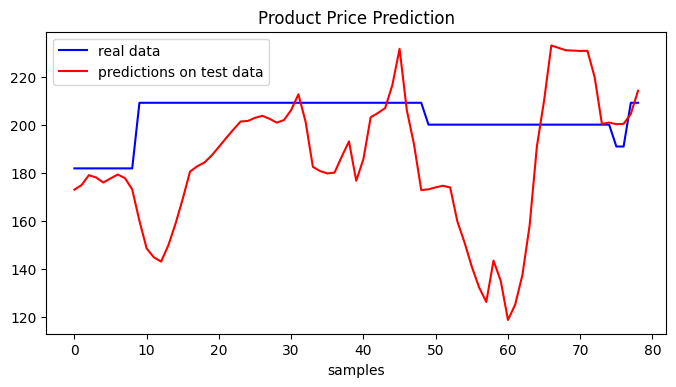

In [72]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "Vanilla LSTM")
multivariate_results.append(metrics)

## Stacked LSTM

In [73]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_companies)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 8, 50)             12000     
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 32,251
Trainable params: 32,251
Non-trainable params: 0
_________________________________________________________________


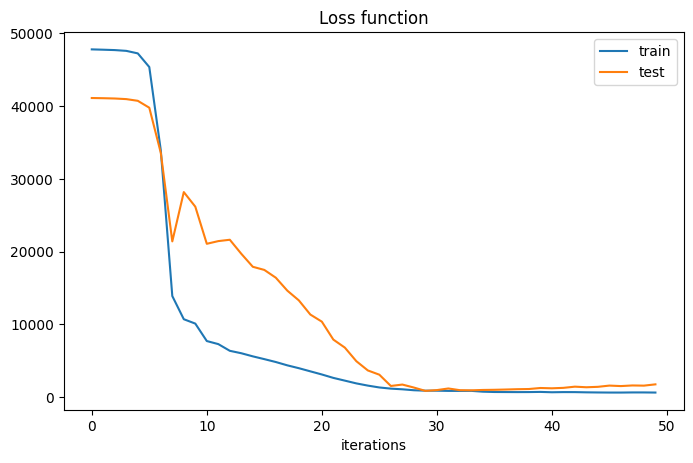

In [74]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                   Value
-----------------------------------  ---------
Mean Absolute Error (MAE)              33.1113
Mean Squared Error (MSE)             1764.64
Root Mean Squared Error (RMSE)         42.0076
Root Mean Squared Log Error (RMSLE)     3.7379
R Squared (R2)                        -21.8049
Adjusted R Squared (AR2)              -24.4111


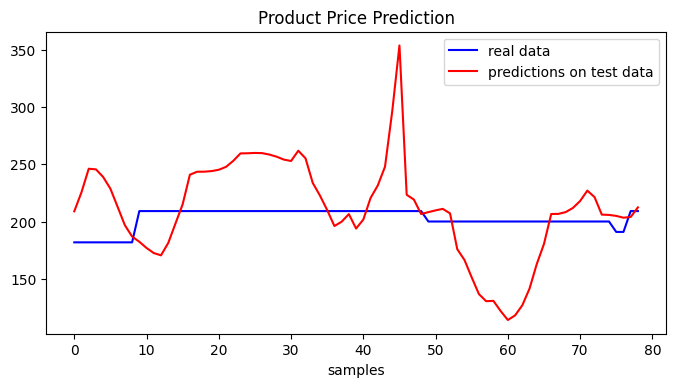

In [75]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "Stacked LSTM")
multivariate_results.append(metrics)

## Bidirectional LSTM

In [76]:
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_companies)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

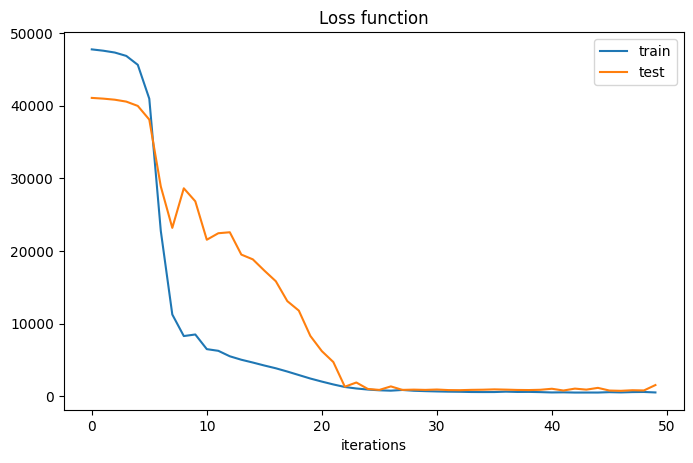

In [77]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                   Value
-----------------------------------  ---------
Mean Absolute Error (MAE)              34.6566
Mean Squared Error (MSE)             1561.95
Root Mean Squared Error (RMSE)         39.5215
Root Mean Squared Log Error (RMSLE)     3.6768
R Squared (R2)                        -19.1854
Adjusted R Squared (AR2)              -21.4923


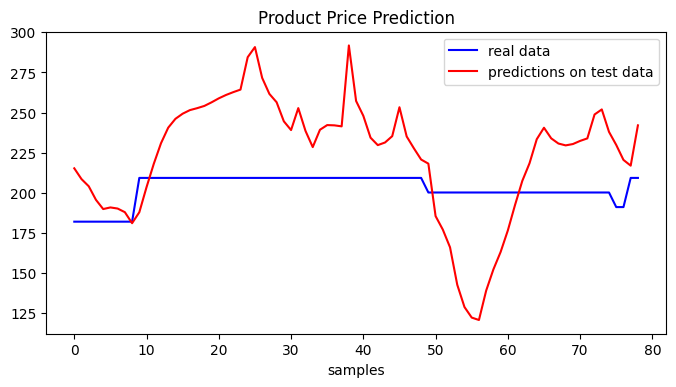

In [78]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "Bidirectional LSTM")
multivariate_results.append(metrics)

## CNN LSTM

In [79]:
# reshape from [samples, timesteps, companies] into [samples, subsequences, timesteps, companies]
n_seq = 2
n_sub_steps = 4
X_train = X_train.reshape((X_train.shape[0], n_seq, n_sub_steps, n_companies))
X_test = X_test.reshape((X_test.shape[0], n_seq, n_sub_steps, n_companies))
print(X_train.shape)
print(X_test.shape)


(183, 2, 4, 9)
(79, 2, 4, 9)


In [80]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_sub_steps, n_companies)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

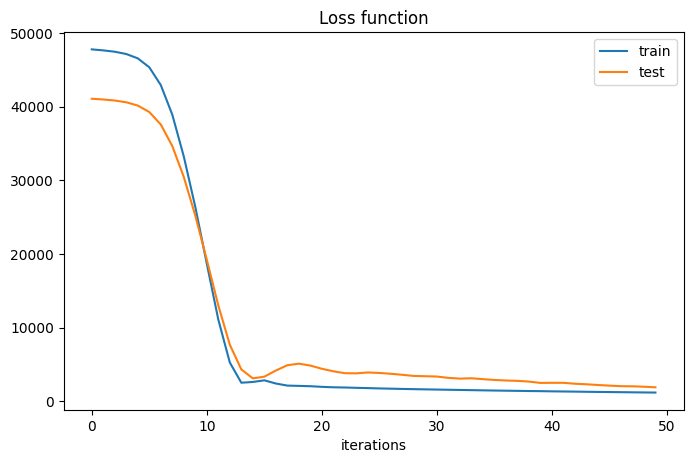

In [81]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                   Value
-----------------------------------  ---------
Mean Absolute Error (MAE)              41.1288
Mean Squared Error (MSE)             1887.28
Root Mean Squared Error (RMSE)         43.4428
Root Mean Squared Log Error (RMSLE)     3.7714
R Squared (R2)                        -23.3897
Adjusted R Squared (AR2)              -24.0316


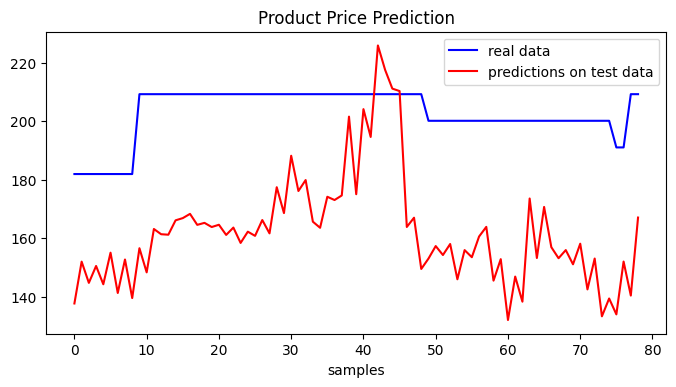

In [82]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "CNN LSTM")
multivariate_results.append(metrics)

## ConvLSTM

In [83]:
X_train = X_train.reshape((X_train.shape[0], n_seq, 1, n_sub_steps, n_companies))
X_test = X_test.reshape((X_test.shape[0], n_seq, 1, n_sub_steps, n_companies))
print(X_train.shape)
print(X_test.shape)

(183, 2, 1, 4, 9)
(79, 2, 1, 4, 9)


In [84]:
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_sub_steps, n_companies)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

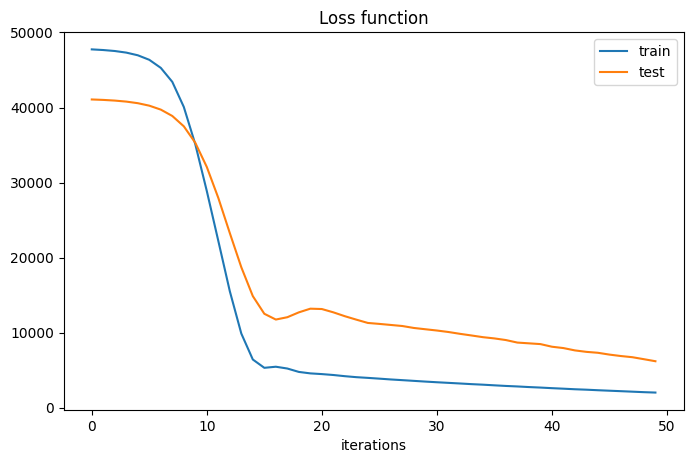

In [85]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                   Value
-----------------------------------  ---------
Mean Absolute Error (MAE)              76.5157
Mean Squared Error (MSE)             6184.3
Root Mean Squared Error (RMSE)         78.6403
Root Mean Squared Log Error (RMSLE)     4.3649
R Squared (R2)                        -78.9212
Adjusted R Squared (AR2)              -81.0244


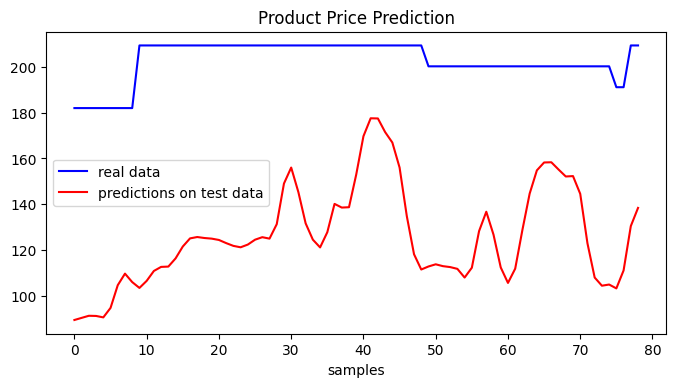

In [86]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "ConvLSTM")
multivariate_results.append(metrics)

## Models Results

In [87]:
print(tabulate(multivariate_results,
               headers=["Multivariate Model", "MAE", "MSE", "RMSE", "RMSLE", "R2", "AR2"], tablefmt='latex_booktabs'
               ))

tabulate(multivariate_results,
         headers=["Multivariate Model", "MAE", "MSE", "RMSE", "RMSLE", "R2", "AR2"], tablefmt='html'
         )


\begin{tabular}{lrrrrrr}
\toprule
 Multivariate Model   &     MAE &      MSE &    RMSE &   RMSLE &       R2 &      AR2 \\
\midrule
 VARMA                &  7.9565 &  100.891 & 10.0445 &  2.307  &  -0.0077 &  -0.1228 \\
 Vanilla LSTM         & 25.1447 & 1092.75  & 33.0567 &  3.4982 & -13.1218 & -14.7358 \\
 Stacked LSTM         & 33.1113 & 1764.64  & 42.0076 &  3.7379 & -21.8049 & -24.4111 \\
 Bidirectional LSTM   & 34.6566 & 1561.95  & 39.5215 &  3.6768 & -19.1854 & -21.4923 \\
 CNN LSTM             & 41.1288 & 1887.28  & 43.4428 &  3.7714 & -23.3897 & -24.0316 \\
 ConvLSTM             & 76.5157 & 6184.3   & 78.6403 &  4.3649 & -78.9212 & -81.0244 \\
\bottomrule
\end{tabular}


Multivariate Model,MAE,MSE,RMSE,RMSLE,R2,AR2
VARMA,7.9565,100.891,10.0445,2.307,-0.0077,-0.1228
Vanilla LSTM,25.1447,1092.75,33.0567,3.4982,-13.1218,-14.7358
Stacked LSTM,33.1113,1764.64,42.0076,3.7379,-21.8049,-24.4111
Bidirectional LSTM,34.6566,1561.95,39.5215,3.6768,-19.1854,-21.4923
CNN LSTM,41.1288,1887.28,43.4428,3.7714,-23.3897,-24.0316
ConvLSTM,76.5157,6184.3,78.6403,4.3649,-78.9212,-81.0244
